In [75]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import sys
sys.path.append('../..')
from tools.cluster_analysis import *
from tools.neural_dataset import *
from tools.evaluation_metrics import *
from tools.evaluate_caterpillar import *
from collections import Counter

In [76]:
def filterer(df):
    return df.loc[df['redshiftstar']<2].copy()

def filter_clusters(df, filter_size):
    counter = Counter(df['cluster_id'].to_numpy())
    large_keys = [key for key in counter.keys() if counter[key] > filter_size]
    key2id = {key:i for i,key in enumerate(large_keys)}
    df = df.loc[df['cluster_id'].isin(large_keys)].copy()
    df['cluster_id'] = df['cluster_id'].apply(lambda key : key2id[key])
    return df

def sample_space(df_, radius=5, radius_sun=8, zsun_range=0.016, sample_size=1000, filter_size=None):
    df = df_.copy()
    phi = np.random.uniform(0, np.pi*2)
    xsun = np.cos(phi)*radius_sun
    ysun = np.sin(phi)*radius_sun
    zsun = np.random.normal(-zsun_range, zsun_range)
    df = df.loc[(df['xstar'].to_numpy()-xsun)**2 + (df['ystar'].to_numpy()-ysun)**2 + (df['zstar'].to_numpy()-zsun)**2 < radius**2]
    if len(df) > sample_size:
        sample_ids = np.random.choice(len(df), min(len(df), sample_size), replace=False)
        df = df.iloc[sample_ids].copy()
    if filter_size is not None:
        df = filter_clusters(df, filter_size)
    return df

In [119]:
def find_IOU_matches(labels, t_labels):
    count_t_labels = Counter(t_labels)
    matches = np.array([False]*len(labels))
    for label in set(labels):
        this_t_labels = t_labels[labels == label]
        other_side = Counter(this_t_labels).most_common()
        ratio = other_side[0][1] / (len(this_t_labels) + count_t_labels[other_side[0][0]] - other_side[0][1])
        if ratio > 1/2:
            print(label, other_side[0])
            matches[(labels == label) | (t_labels == other_side[0][0])] = True
    return matches

In [127]:
def evaluate(dataset_id, n_components):
    clusterer = C_GaussianMixture(n_components=n_components)
    feature_columns = ['estar', 'jrstar', 'jzstar', 'jphistar', 'rstar', 'vstar', 'vxstar', 'vystar', 'vzstar', 'vrstar', 'vphistar', 'phistar', 'zstar']
    dataset = PointDataset(feature_columns, 'cluster_id')
    dataset_root = '../../data/caterpillar/labeled_caterpillar_data'
    print(f'evaluating {dataset_id}')
    dataset_name = f'labeled_{dataset_id}_0'
    df_ = pd.read_hdf(os.path.join(dataset_root, dataset_name+'.h5'), key='star')
    df_ = filterer(df_)
    with open(os.path.join(dataset_root, dataset_name+'_norm.json'), 'r') as f:
        df_norm = json.load(f)
    df = sample_space(df_, radius=0.01, radius_sun=0.0082, zsun_range=0.016/1000, sample_size=1000000, filter_size=10)
    print(f'size of dataset: {len(df)}')
    dataset.load_data(df, df_norm)
    clusterer.add_data(dataset)
    labels = clusterer.fit() # if gnn, it would output loss as well
    if torch.is_tensor(labels):
        labels = labels.detach().cpu().numpy()
    t_labels = dataset.labels
    if torch.is_tensor(t_labels):
        t_labels = t_labels.detach().cpu().numpy()
    cluster_eval = ClusterEvalAll(labels, t_labels)
    metric = cluster_eval()
    print(metric)
    true_matches = find_IOU_matches(labels, t_labels)
    print(len(np.argwhere(true_matches==True)))
    f_labels = np.array([f'cluster {label}' for label in labels])
    ft_labels = np.array([f'cluster {t_label}' for t_label in t_labels])
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    custom_xlim = (-4.5, 4.5)
    custom_ylim = (20000, 120000)
    plt.setp(axes, xlim=custom_xlim, ylim=custom_ylim)
    pt1 = sns.scatterplot(data=df, ax=axes[0,0], x='jphistar', y='estar', hue=f_labels)
    pt2 = sns.scatterplot(data=df, ax=axes[0,1], x='jphistar', y='estar', hue=ft_labels)
    df_trim = df.iloc[true_matches]
    pt3 = sns.scatterplot(data=df_trim, ax=axes[1,0], x='jphistar', y='estar', hue=f_labels[true_matches])
    pt4 = sns.scatterplot(data=df_trim, ax=axes[1,1], x='jphistar', y='estar', hue=ft_labels[true_matches])
    for ax in axes.flatten()[:2]:
        ax.legend([],[], frameon=False)
    
    

evaluating 94638
size of dataset: 2643
{'IoU_TP': 2, 'IoU_T': 43, 'IoU_P': 50, 'IoU_precision': 0.04, 'IoU_recall': 0.046511627906976744, 'IoU_F1': 0.04301075268817204, 'Mode_TP': 20, 'Mode_T': 43, 'Mode_P': 50, 'Mode_precision': 0.4, 'Mode_recall': 0.46511627906976744, 'Mode_F1': 0.4301075268817204, 'Mode_TP_C': 356, 'Mode_recall_C': 0.13469542186908814, 'Purity': 0.2565266742338252, 'AMI': 0.17973365467444113, 'ARand': 0.05200052930706808, 'ModeProb_TP': 5, 'ModeProb_T': 43, 'ModeProb_P': 50, 'ModeProb_precision': 0.1, 'ModeProb_recall': 0.11627906976744186, 'ModeProb_F1': 0.1075268817204301}
7 (41, 31)
12 (13, 46)
90


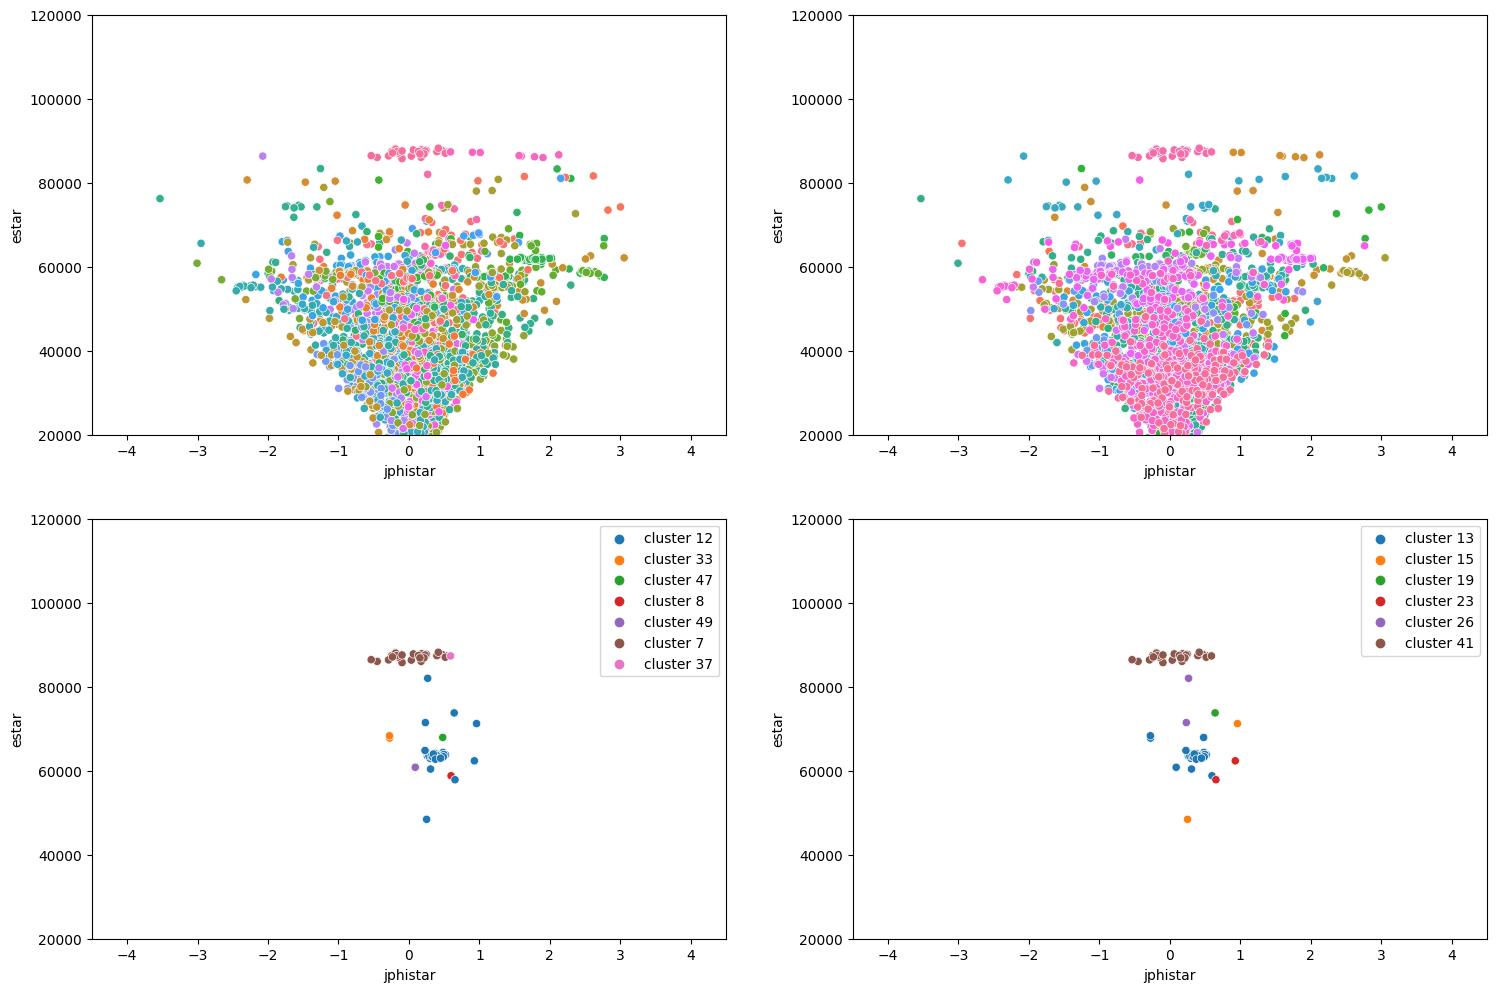

In [134]:
evaluate(94638, 50)    